In [ ]:
from __future__ import division, print_function
import fractions
import functools
import re

import numpy as np
from scipy.spatial import ConvexHull

import ase.units as units
from ase.atoms import string2symbols
from ase.utils import formula_hill, basestring

_solvated = []


def parse_formula(formula):
    aq = formula.endswith('(aq)')
    if aq:
        formula = formula[:-4]
    charge = formula.count('+') - formula.count('-')
    if charge:
        formula = formula.rstrip('+-')
    count = {}
    for symbol in string2symbols(formula):
        count[symbol] = count.get(symbol, 0) + 1
    return count, charge, aq


def float2str(x):
    f = fractions.Fraction(x).limit_denominator(100)
    n = f.numerator
    d = f.denominator
    if abs(n / d - f) > 1e-6:
        return '{0:.3f}'.format(f)
    if d == 0:
        return '0'
    if f.denominator == 1:
        return str(n)
    return '{0}/{1}'.format(f.numerator, f.denominator)


def solvated(symbols):
    """Extract solvation energies from database.

    symbols: str
        Extract only those molecules that contain the chemical elements
        given by the symbols string (plus water and H+).

    Data from:

        Johnson JW, Oelkers EH, Helgeson HC (1992)
        Comput Geosci 18(7):899.
        doi:10.1016/0098-3004(92)90029-Q

    and:

        Pourbaix M (1966)
        Atlas of electrochemical equilibria in aqueous solutions.
        No. v. 1 in Atlas of Electrochemical Equilibria in Aqueous Solutions.
        Pergamon Press, New York.

    Returns list of (name, energy) tuples.
    """

    if isinstance(symbols, basestring):
        symbols = set(string2symbols(symbols))
    if len(_solvated) == 0:
        for line in _aqueous.splitlines():
            energy, formula = line.split(',')
            name = formula + '(aq)'
            count, charge, aq = parse_formula(name)
            energy = float(energy) * 0.001 * units.kcal / units.mol
            _solvated.append((name, count, charge, aq, energy))
    references = []
    for name, count, charge, aq, energy in _solvated:
        for symbol in count:
            if symbol not in 'HO' and symbol not in symbols:
                break
        else:
            references.append((name, energy))
    return references



def bisect(A, X, Y, f):
    a = []
    for i in [0, -1]:
        for j in [0, -1]:
            if A[i, j] == -1:
                A[i, j] = f(X[i], Y[j])
            a.append(A[i, j])

    if np.ptp(a) == 0:
        A[:] = a[0]
        return
    if a[0] == a[1]:
        A[0] = a[0]
    if a[1] == a[3]:
        A[:, -1] = a[1]
    if a[3] == a[2]:
        A[-1] = a[3]
    if a[2] == a[0]:
        A[:, 0] = a[2]
    if not (A == -1).any():
        return
    i = len(X) // 2
    j = len(Y) // 2
    bisect(A[:i + 1, :j + 1], X[:i + 1], Y[:j + 1], f)
    bisect(A[:i + 1, j:], X[:i + 1], Y[j:], f)
    bisect(A[i:, :j + 1], X[i:], Y[:j + 1], f)
    bisect(A[i:, j:], X[i:], Y[j:], f)


def print_results(results):
    total_energy = 0.0
    print('reference    coefficient      energy')
    print('------------------------------------')
    for name, coef, energy in results:
        total_energy += coef * energy
        if abs(coef) < 1e-7:
            continue
        print('{0:14}{1:>10}{2:12.3f}'.format(name, float2str(coef), energy))
    print('------------------------------------')
    print('Total energy: {0:22.3f}'.format(total_energy))
    print('------------------------------------')


class Pourbaix:
    def __init__(self, references, formula=None, T=300.0, **kwargs):
        """Pourbaix object.

        references: list of (name, energy) tuples
            Examples of names: ZnO2, H+(aq), H2O(aq), Zn++(aq), ...
        formula: str
            Stoichiometry.  Example: ``'ZnO'``.  Can also be given as
            keyword arguments: ``Pourbaix(refs, Zn=1, O=1)``.
        T: float
            Temperature in Kelvin.
        """

        if formula:
            assert not kwargs
            kwargs = parse_formula(formula)[0]

        self.kT = units.kB * T
        self.references = []
        for name, energy in references:
            if name == 'O':
                continue
            count, charge, aq = parse_formula(name)
            for symbol in count:
                if aq:
                    if not (symbol in 'HO' or symbol in kwargs):
                        break
                else:
                    if symbol not in kwargs:
                        break
            else:
                self.references.append((count, charge, aq, energy, name))

        self.references.append(({}, -1, False, 0.0, 'e-'))  # an electron

        self.count = kwargs

        if 'O' not in self.count:
            self.count['O'] = 0

        self.N = {'e-': 0, 'H': 1}
        for symbol in kwargs:
            if symbol not in self.N:
                self.N[symbol] = len(self.N)

    def decompose(self, U, pH, verbose=True, concentration=1e-6):
        """Decompose material.

        U: float
            Potential in V.
        pH: float
            pH value.
        verbose: bool
            Default is True.
        concentration: float
            Concentration of solvated references.

        Returns optimal coefficients and energy.
        """

        alpha = np.log(10) * self.kT
        entropy = -np.log(concentration) * self.kT

        # We want to minimize np.dot(energies, x) under the constraints:
        #
        #     np.dot(x, eq2) == eq1
        #
        # with bounds[i,0] <= x[i] <= bounds[i, 1].
        #
        # First two equations are charge and number of hydrogens, and
        # the rest are the remaining species.

        eq1 = [0, 0] + list(self.count.values())
        eq2 = []
        energies = []
        bounds = []
        names = []
        for count, charge, aq, energy, name in self.references:
            eq = np.zeros(len(self.N))
            eq[0] = charge
            for symbol, n in count.items():
                eq[self.N[symbol]] = n
            eq2.append(eq)
            if name in ['H2O(aq)', 'H+(aq)', 'e-']:
                bounds.append((-np.inf, np.inf))
                if name == 'e-':
                    energy = -U
                elif name == 'H+(aq)':
                    energy = -pH * alpha
            else:
                bounds.append((0, 1))
                if aq:
                    energy -= entropy
            if verbose:
                print('{0:<5}{1:10}{2:10.3f}'.format(len(energies),
                                                     name, energy))
            energies.append(energy)
            names.append(name)

        try:
            from scipy.optimize import linprog
        except ImportError:
            from ase.utils._linprog import linprog
        result = linprog(energies, None, None, np.transpose(eq2), eq1, bounds)

        if verbose:
            print_results(zip(names, result.x, energies))

        return result.x, result.fun


    def diagram(self, U, pH, plot=True, show=True, ax=None):
        """Calculate Pourbaix diagram.

        U: list of float
            Potentials in V.
        pH: list of float
            pH values.
        plot: bool
            Create plot.
        show: bool
            Open graphical window and show plot.
        ax: matplotlib axes object
            When creating plot, plot onto the given axes object.
            If none given, plot onto the current one.
        """
        a = np.empty((len(U), len(pH)), int)
        a[:] = -1
        colors = {}
        f = functools.partial(self.colorfunction, colors=colors)
        bisect(a, U, pH, f)
        compositions = [None] * len(colors)
        names = [ref[-1] for ref in self.references]
        for indices, color in colors.items():
            compositions[color] = ' + '.join(names[i] for i in indices
                                             if names[i] not in
                                             ['H2O(aq)', 'H+(aq)', 'e-'])
        text = []
        for i, name in enumerate(compositions):
            b = (a == i)
            x = np.dot(b.sum(1), U) / b.sum()
            y = np.dot(b.sum(0), pH) / b.sum()
            name = re.sub('(\S)([+-]+)', r'\1$^{\2}$', name)
            name = re.sub('(\d+)', r'$_{\1}$', name)
            text.append((x, y, name))

        if plot:
            import matplotlib.pyplot as plt
            import matplotlib.cm as cm
            if ax is None:
                ax = plt.gca()

            # rasterized pcolormesh has a bug which leaves a tiny
            # white border.  Unrasterized pcolormesh produces
            # unreasonably large files.  Avoid this by using the more
            # general imshow.
            ax.imshow(a, cmap=cm.Accent,
                      extent=[min(pH), max(pH), min(U), max(U)],
                      origin='lower',
                      aspect='auto')

            for x, y, name in text:
                ax.text(y, x, name, horizontalalignment='center')
            ax.set_xlabel('pH')
            ax.set_ylabel('potential [V]')
            ax.set_xlim(min(pH), max(pH))
            ax.set_ylim(min(U), max(U))
            if show:
                plt.show()

        return a, compositions, text


    def colorfunction(self, U, pH, colors):
        coefs, energy = self.decompose(U, pH, verbose=False)
        indices = tuple(sorted(np.where(abs(coefs) > 1e-7)[0]))
        color = colors.get(indices)
        if color is None:
            color = len(colors)
            colors[indices] = color
        return color

_aqueous = """\
-525700,SiF6--
-514100,Rh(SO4)3----
-504800,Ru(SO4)3----
-499900,Pd(SO4)3----
-495200,Ru(SO4)3---
-485700,H4P2O7
-483700,Rh(SO4)3---
-483600,H3P2O7-
-480400,H2P2O7--
-480380,Pt(SO4)3----
-471400,HP2O7---
-458700,P2O7----
-447500,LaF4-
-437600,LaH2PO4++
-377900,LaF3
-376299,Ca(HSiO3)+
-370691,BeF4--
-355400,BF4-
-353025,Mg(HSiO3)+
-346900,LaSO4+
-334100,Rh(SO4)2--
-325400,Ru(SO4)2--
-319640,Pd(SO4)2--
-317900,Ru(SO4)2-
-312970,Cr2O7--
-312930,CaSO4
-307890,NaHSiO3
-307800,LaF2+
-307000,LaHCO3++
-306100,Rh(SO4)2-
-302532,BeF3-
-300670,Pt(SO4)2--
-299900,LaCO3+
-289477,MgSO4
-288400,LaCl4-
-281500,HZrO3-
-279200,HHfO3-
-276720,Sr(HCO3)+
-275700,Ba(HCO3)+
-273830,Ca(HCO3)+
-273100,H3PO4
-270140,H2PO4-
-266500,S2O8--
-264860,Sr(CO3)
-264860,SrCO3
-263830,Ba(CO3)
-263830,BaCO3
-262850,Ca(CO3)
-262850,CaCO3
-260310,HPO4--
-257600,LaCl3
-250200,Mg(HCO3)+
-249200,H3VO4
-248700,S4O6--
-246640,KSO4-
-243990,H2VO4-
-243500,PO4---
-243400,KHSO4
-242801,HSiO3-
-241700,HYO2
-241476,NaSO4-
-239700,HZrO2+
-239300,LaO2H
-238760,Mg(CO3)
-238760,MgCO3
-237800,HHfO2+
-236890,Ag(CO3)2---
-236800,HNbO3
-236600,LaF++
-235640,MnSO4
-233400,ZrO2
-233000,HVO4--
-231600,HScO2
-231540,B(OH)3
-231400,HfO2
-231386,BeF2
-231000,S2O6--
-229000,S3O6--
-229000,S5O6--
-228460,HTiO3-
-227400,YO2-
-227100,NbO3-
-226700,LaCl2+
-223400,HWO4-
-221700,LaO2-
-218500,WO4--
-218100,ScO2-
-214900,VO4---
-210000,YOH++
-208900,LaOH++
-207700,HAlO2
-206400,HMoO4-
-204800,H3PO3
-202350,H2PO3-
-202290,SrF+
-201807,BaF+
-201120,BaF+
-200400,MoO4--
-200390,CaF+
-199190,SiO2
-198693,AlO2-
-198100,YO+
-195900,LaO+
-195800,LaCl++
-194000,CaCl2
-194000,HPO3--
-191300,LaNO3++
-190400,ZrOH+++
-189000,HfOH+++
-189000,S2O5--
-187600,ZrO++
-186000,HfO++
-183700,HCrO4-
-183600,ScO+
-183100,H3AsO4
-180630,HSO4-
-180010,H2AsO4-
-177930,SO4--
-177690,MgF+
-174800,CrO4--
-173300,SrOH+
-172300,BaOH+
-172200,HBeO2-
-171300,CaOH+
-170790,HAsO4--
-166000,ReO4-
-165800,SrCl+
-165475,Al(OH)++
-165475,AlOH++
-164730,BaCl+
-164000,La+++
-163800,Y+++
-163100,CaCl+
-162240,BO2-
-158493,BeF+
-158188,AlO+
-155700,VOOH+
-155164,CdF2
-154970,AsO4---
-153500,Rh(SO4)
-152900,BeO2--
-152370,HSO5-
-151540,RuCl6---
-149255,MgOH+
-147400,H2S2O4
-146900,HS2O4-
-146081,CdCl4--
-145521,BeCl2
-145200,Ru(SO4)
-145056,PbF2
-143500,S2O4--
-140330,H2AsO3-
-140300,VO2+
-140282,HCO3-
-140200,Sc+++
-139900,BeOH+
-139700,MgCl+
-139200,Ru(SO4)+
-139000,Pd(SO4)
-138160,HF2-
-138100,HCrO2
-138000,TiO++
-137300,HGaO2
-136450,RbF
-134760,Sr++
-134030,Ba++
-133270,Zr++++
-133177,PbCl4--
-132600,Hf++++
-132120,Ca++
-129310,ZnCl3-
-128700,GaO2-
-128600,BeO
-128570,NaF
-128000,H2S2O3
-127500,Rh(SO4)+
-127200,HS2O3-
-126191,CO3--
-126130,HSO3-
-125300,CrO2-
-125100,H3PO2
-124900,S2O3--
-123641,MnF+
-122400,H2PO2-
-121000,HMnO2-
-120700,RuCl5--
-120400,MnO4--
-120300,Pt(SO4)
-119800,HInO2
-116300,SO3--
-115971,CdCl3-
-115609,Al+++
-115316,BeCl+
-112280,AgCl4---
-111670,TiO2++
-111500,VOH++
-111430,Ag(CO3)-
-110720,HZnO2-
-108505,Mg++
-108100,HSeO4-
-108000,LiOH
-107600,MnO4-
-106988,HgCl4--
-106700,InO2-
-106700,VO++
-106100,VO+
-105500,SeO4--
-105100,RbOH
-105000,CsOH
-104500,KOH
-104109,ZnF+
-103900,PdCl4--
-103579,CuCl4--
-102600,MnO2--
-102150,PbCl3-
-101850,H2SeO3
-101100,HFeO2
-100900,CsCl
-100500,CrOH++
-99900,NaOH
-99800,VOH+
-99250,LiCl
-98340,HSeO3-
-98300,ZnCl2
-97870,RbCl
-97400,HSbO2
-97300,HSnO2-
-97300,MnOH+
-97016,InF++
-96240,HAsO2
-95430,KCl
-95400,HFeO2-
-94610,CsBr
-93290,ZnO2--
-93250,RhCl4--
-92910,NaCl
-92800,CrO+
-92250,CO2
-91210,PtCl4--
-91157,FeF+
-91100,GaOH++
-91010,RbBr
-90550,Be++
-90010,KBr
-89963,CuCl3--
-89730,RuCl4-
-88400,SeO3--
-88000,FeO2-
-87373,CdF+
-86600,GaO+
-86500,HCdO2-
-86290,MnCl+
-85610,NaBr
-84851,CdCl2
-83900,RuCl4--
-83650,AsO2-
-83600,Ti+++
-83460,CsI
-83400,HCoO2-
-82710,AgCl3--
-82400,SbO2-
-81980,HNiO2-
-81732,CoF+
-81500,MnO
-81190,ZnOH+
-81000,HPbO2-
-79768,NiF+
-79645,FeF++
-79300,HBiO2
-78900,RbI
-77740,KI
-77700,La++
-77500,RhCl4-
-75860,PbF+
-75338,CuCl3-
-75216,TlF
-75100,Ti++
-74600,InOH++
-74504,HgCl3-
-73480,FeCl2
-72900,NaI
-71980,SO2
-71662,HF
-71600,RuO4--
-71200,PbCl2
-69933,Li+
-69810,PdCl3-
-69710,Cs+
-69400,InO+
-67811,AuCl3--
-67800,Rb+
-67510,K+
-67420,ZnO
-67340,F-
-67300,CdO2--
-66850,ZnCl+
-65850,FeOH+
-65550,TlOH
-64200,NiO2--
-63530,RhCl3-
-63200,CoO2--
-62591,Na+
-61700,BiO2-
-61500,CdOH+
-60100,HCuO2-
-59226,InCl++
-58600,SnOH+
-58560,RuCl3
-58038,CuCl2-
-57900,V+++
-57800,FeOH++
-57760,PtCl3-
-57600,HTlO2
-56690,H2O
-56025,CoOH+
-55100,Mn++
-54380,RuCl3-
-53950,PbOH+
-53739,CuF+
-53600,SnO
-53100,FeO+
-53030,FeCl+
-52850,NiOH+
-52627,CdCl+
-52000,V++
-51560,AgCl2-
-50720,FeO
-49459,AgF
-49300,Cr+++
-47500,CdO
-46190,RhCl3
-46142,CuCl2
-45200,HHgO2-
-45157,CoCl+
-44000,CoO
-42838,HgCl2
-41600,TlO2-
-41200,CuO2--
-40920,NiCl+
-39815,TlCl
-39400,Cr++
-39350,PbO
-39340,NiO
-39050,PbCl+
-38000,Ga+++
-37518,FeCl++
-36781,AuCl2-
-35332,AuCl4-
-35200,Zn++
-35160,PdCl2
-33970,RhCl2
-32300,BiOH++
-31700,HIO3
-31379,Cl-
-30600,IO3-
-30410,HCl
-30204,HgF+
-30200,CuOH+
-29300,BiO+
-28682,CO
-26507,NO3-
-26440,RuCl2+
-25590,Br3-
-25060,RuCl2
-24870,Br-
-24730,HNO3
-23700,HIO
-23400,In+++
-23280,OCN-
-23000,CoOH++
-22608,CuCl
-22290,PtCl2
-21900,AgOH
-21870,Fe++
-20800,CuO
-20300,Mn+++
-20058,Pb(HS)2
-19700,HBrO
-19100,HClO
-19100,ScOH++
-18990,NH4+
-18971,Pb(HS)3-
-18560,Cd++
-18290,Rh(OH)+
-17450,AgCl
-16250,CuCl+
-14780,RhCl2+
-14000,IO4-
-13130,Pd(OH)+
-13000,Co++
-12700,HgOH+
-12410,I-
-12300,I3-
-12190,Ru(OH)2++
-12100,HNO2
-11500,PdO
-10900,Ni++
-10470,Ru(OH)+
-10450,RuO+
-9200,IO-
-8900,HgO
-8800,ClO-
-8000,BrO-
-7740,Tl+
-7738,AgNO3
-7700,NO2-
-7220,RhO
-6673,H2S
-6570,Sn++
-6383,NH3
-5710,Pb++
-5500,AgO-
-4500,TlOH++
-4120,Fe+++
-3380,RhCl+
-3200,TlO+
-3184,AuCl
-2155,HgCl+
-2040,ClO4-
-1900,ClO3-
-1130,PtO
-820,Rh(OH)++
0,Ag(HS)2-
0,H+
230,RuO
1400,HClO2
1560,Pt(OH)+
2429,Au(HS)2-
2500,PdCl+
2860,HS-
3140,RhO+
3215,Xe
3554,Kr
3890,Ar
4100,ClO2-
4347,N2
4450,BrO3-
4565,Ne
4658,He
5210,RuCl+
7100,RuCl++
8600,H2N2O2
9375,TlCl++
10500,HSe-
11950,Cu+
15675,Cu++
15700,S5--
16500,S4--
17600,S3--
18200,HN2O2-
18330,RhCl++
18380,PtCl+
18427,Ag+
19000,S2--
19500,SeCN-
19700,N2H5+
21100,N2H6++
22160,SCN-
22880,Bi+++
27700,Rh++
28200,BrO4-
28600,HCN
32000,Co+++
33200,N2O2--
35900,Ru++
36710,Hg2++
39360,Hg++
41200,CN-
41440,Ru+++
42200,Pd++
51300,Tl+++
52450,Rh+++
61600,Pt++
64300,Ag++
103600,Au+++"""

[('HZnO2-(aq)', -4.801273583873681), ('ZnO2--(aq)', -4.045437252886342), ('ZnOH+(aq)', -3.5207315956891634), ('ZnO(aq)', -2.923607884977995), ('H2O(aq)', -2.45831105012463), ('Zn++(aq)', -1.5264164573008816), ('H+(aq)', 0.0), ('Zn', 0.0), ('ZnO', -3.323), ('ZnO2(aq)', -2.921), ('Cu', 0.0), ('HCuO2-(aq)', -2.606182644425653), ('H2O(aq)', -2.45831105012463), ('CuO2--(aq)', -1.7866010807044408), ('CuOH+(aq)', -1.3095959377979152), ('CuO(aq)', -0.9019733611323391), ('H+(aq)', 0.0), ('Cu+(aq)', 0.5182010416120891), ('Cu++(aq)', 0.6797323286417988)]


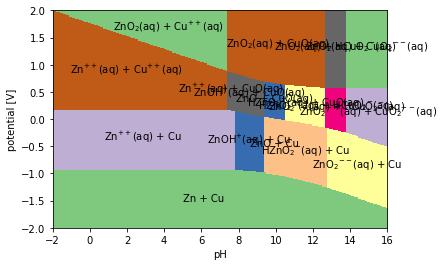

['Zn + Cu', 'ZnO2(aq) + Cu++(aq)', 'ZnO2(aq) + CuO2--(aq)', 'Zn++(aq) + Cu', 'ZnO2--(aq) + CuO2--(aq)', 'HZnO2-(aq) + Cu', 'ZnO + Cu', 'ZnO2--(aq) + Cu', 'HZnO2-(aq) + CuO(aq)', 'ZnOH+(aq) + Cu', 'ZnO + CuO(aq)', 'ZnO2--(aq) + HCuO2-(aq)', 'HZnO2-(aq) + HCuO2-(aq)', 'Zn++(aq) + Cu++(aq)', 'ZnO2(aq) + CuO(aq)', 'ZnOH+(aq) + CuO(aq)', 'Zn++(aq) + CuO(aq)', 'ZnO2(aq) + HCuO2-(aq)']


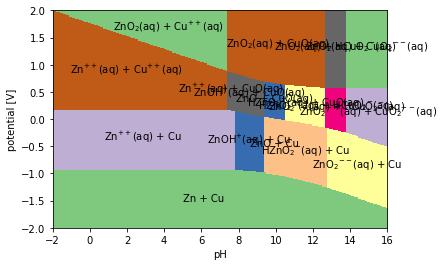

<type 'tuple'>


In [31]:
##we may not need solvated data as it is from ASE databases,
##we would like to have something from our own database
refs = solvated('Zn')   #solvated function is to filter the ions from the database, 
                        #keep the format
refs1 = solvated('Cu')
# print(refs)
# print(refs1)
# create a list contains all alloys or solids
refs += [('Zn', 0.0), ('ZnO', -3.323), ('ZnO2(aq)', -2.921), ('Cu',0.0)] 
#add solid and aqueous neutral species
refs += refs1 ##can we get reference energies from somewhere else?
print(refs)
pb = Pourbaix(refs, Zn=1, Cu = 1, O =1) ##if it can be adjusted as elem0= 1, elem1 = 1, O = 1??
U = np.linspace(-2, 2, 200)
pH = np.linspace(-2, 16, 300)
d, names, text = pb.diagram(U, pH, plot=True)
print(names)                                    ##ASE considers single metal system which 
                                                #may be oversimplified in binary systems
print(type(pb.diagram(U, pH, plot=True)))